# Text Cleaning Pipeline for Sentiment Analysis

## Overview
This notebook implements a comprehensive text cleaning pipeline for Twitter sentiment analysis data. The goal is to preprocess raw tweets to make them suitable for various word embedding techniques and model architectures.

## Dataset Information
- **Source**: Twitter_Data.csv
- **Columns**: clean_text (tweet content), category (sentiment label: -1, 0, 1)
- **Sentiment Labels**:
  - -1: Negative
  - 0: Neutral
  - 1: Positive

## Text Cleaning Approach
We will implement multiple cleaning strategies:
1. **Basic Cleaning**: Remove URLs, mentions, hashtags, special characters
2. **Normalization**: Lowercase conversion, whitespace normalization
3. **Noise Removal**: Remove numbers, punctuation, extra spaces
4. **Advanced Cleaning**: Handle contractions, remove stopwords, lemmatization
5. **Multiple Versions**: Create different cleaned versions for different embedding techniques

## 1. Import Required Libraries

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saurabhshahane/twitter-sentiment-dataset")

print("Path to dataset files:", path)

100%|██████████| 7.60M/7.60M [00:01<00:00, 6.15MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saurabhshahane/twitter-sentiment-dataset/versions/1


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import string
from collections import Counter

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_colwidth', 200)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Download NLTK Resources

Download necessary NLTK data for text processing operations.

In [3]:
# Download required NLTK data
nltk_resources = ['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'punkt_tab']

for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"✓ {resource} downloaded successfully")
    except Exception as e:
        print(f"✗ Error downloading {resource}: {e}")

print("\nNLTK resources ready!")

✓ punkt downloaded successfully
✓ stopwords downloaded successfully
✓ wordnet downloaded successfully
✓ omw-1.4 downloaded successfully
✓ punkt_tab downloaded successfully

NLTK resources ready!


## 3. Load Raw Data

Load the Twitter sentiment dataset from the raw data directory.

In [6]:
# Load the dataset
df = pd.read_csv(f'{path}/Twitter_Data.csv')

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nSentiment Distribution:\n{df['category'].value_counts().sort_index()}")

# Display sample records
print("\n" + "="*80)
print("Sample Records:")
print("="*80)
df.head()

Dataset Shape: (162980, 2)

Columns: ['clean_text', 'category']

Data Types:
clean_text     object
category      float64
dtype: object

Missing Values:
clean_text    4
category      7
dtype: int64

Sentiment Distribution:
category
-1.0    35510
 0.0    55213
 1.0    72250
Name: count, dtype: int64

Sample Records:


,clean_text,category
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit ps...,-1.0
1,talk all the nonsense and continue all the drama will vote for modi,0.0
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,1.0
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming...,1.0
4,answer who among these the most powerful world leader today trump putin modi may,1.0


## 4. Exploratory Analysis of Raw Text

Analyze the characteristics of raw text data before cleaning.

In [7]:
# Analyze text length distribution
df['text_length'] = df['clean_text'].astype(str).apply(len)
df['word_count'] = df['clean_text'].astype(str).apply(lambda x: len(x.split()))

print("Text Length Statistics:")
print(df[['text_length', 'word_count']].describe())

# Check for special patterns
df['has_url'] = df['clean_text'].astype(str).apply(lambda x: bool(re.search(r'http[s]?://\S+|www\.\S+', x)))
df['has_mention'] = df['clean_text'].astype(str).apply(lambda x: bool(re.search(r'@\w+', x)))
df['has_hashtag'] = df['clean_text'].astype(str).apply(lambda x: bool(re.search(r'#\w+', x)))
df['has_number'] = df['clean_text'].astype(str).apply(lambda x: bool(re.search(r'\d+', x)))

print("\n" + "="*50)
print("Special Pattern Presence:")
print("="*50)
print(f"Tweets with URLs: {df['has_url'].sum()} ({df['has_url'].mean()*100:.2f}%)")
print(f"Tweets with Mentions: {df['has_mention'].sum()} ({df['has_mention'].mean()*100:.2f}%)")
print(f"Tweets with Hashtags: {df['has_hashtag'].sum()} ({df['has_hashtag'].mean()*100:.2f}%)")
print(f"Tweets with Numbers: {df['has_number'].sum()} ({df['has_number'].mean()*100:.2f}%)")

Text Length Statistics:
         text_length     word_count
count  162980.000000  162980.000000
mean      124.173518      20.079948
std        67.925104      10.879775
min         1.000000       0.000000
25%        66.000000      11.000000
50%       114.000000      18.000000
75%       183.000000      29.000000
max       274.000000      52.000000

Special Pattern Presence:
Tweets with URLs: 0 (0.00%)
Tweets with Mentions: 0 (0.00%)
Tweets with Hashtags: 0 (0.00%)
Tweets with Numbers: 25320 (15.54%)


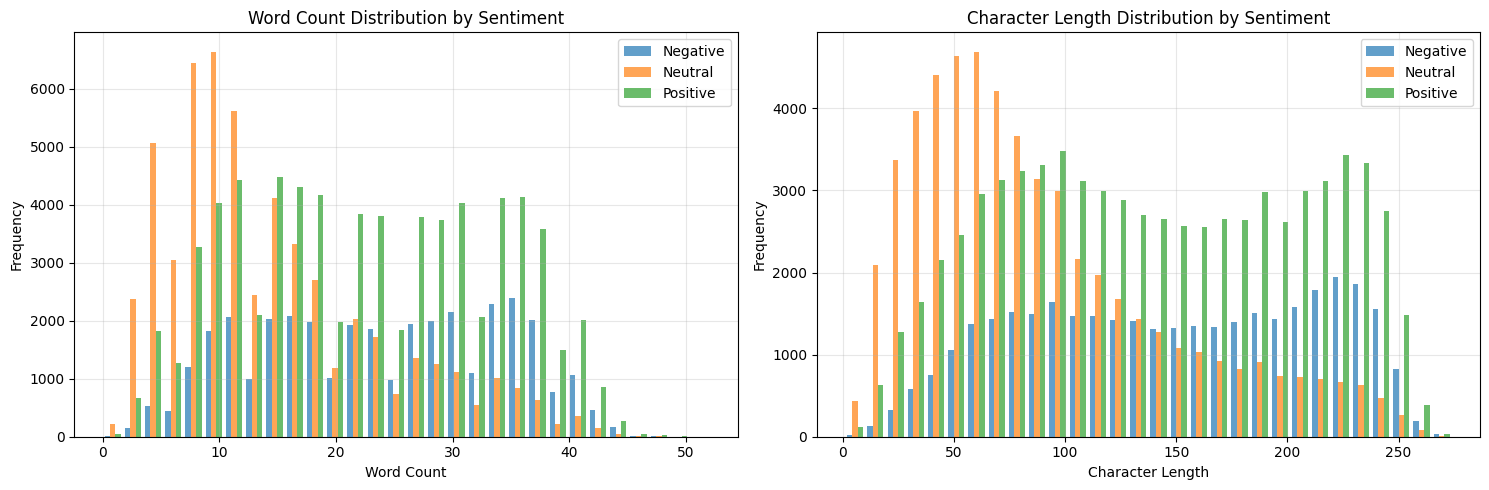

In [8]:
# Visualize text length distribution by sentiment
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Word count distribution
axes[0].hist([df[df['category']==-1]['word_count'],
              df[df['category']==0]['word_count'],
              df[df['category']==1]['word_count']],
             label=['Negative', 'Neutral', 'Positive'],
             bins=30, alpha=0.7)
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Word Count Distribution by Sentiment')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Character length distribution
axes[1].hist([df[df['category']==-1]['text_length'],
              df[df['category']==0]['text_length'],
              df[df['category']==1]['text_length']],
             label=['Negative', 'Neutral', 'Positive'],
             bins=30, alpha=0.7)
axes[1].set_xlabel('Character Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Character Length Distribution by Sentiment')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Define Text Cleaning Functions

Create modular functions for different text cleaning operations. Each function serves a specific purpose in the cleaning pipeline.

### 5.1 Basic Cleaning Functions

In [9]:
def remove_urls(text):
    """
    Remove URLs from text.
    Handles http://, https://, www., and shortened URLs.
    """
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    text = re.sub(r'www\.\S+', '', text)
    return text

def remove_mentions(text):
    """
    Remove Twitter mentions (@username).
    """
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    """
    Remove hashtag symbols but keep the text.
    Example: #modi -> modi
    """
    return re.sub(r'#', '', text)

def remove_special_characters(text, keep_punctuation=False):
    """
    Remove special characters and digits.
    Option to keep basic punctuation for some embedding techniques.
    """
    if keep_punctuation:
        # Keep basic punctuation: . , ! ?
        pattern = r'[^a-zA-Z\s.,!?]'
    else:
        pattern = r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

def remove_extra_whitespace(text):
    """
    Remove extra whitespace, tabs, and newlines.
    """
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def to_lowercase(text):
    """
    Convert text to lowercase.
    """
    return text.lower()

print("✓ Basic cleaning functions defined")

✓ Basic cleaning functions defined


### 5.2 Advanced Cleaning Functions

In [10]:
# Define contractions dictionary
CONTRACTIONS = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "'s": "",  # Handle possessives
    "'re": " are",
    "'ve": " have",
    "'d": " would",
    "'ll": " will",
}

def expand_contractions(text):
    """
    Expand contractions in text.
    Example: "don't" -> "do not"
    """
    text = text.lower()
    for contraction, expansion in CONTRACTIONS.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text)
    return text

def remove_stopwords(text, custom_stopwords=None):
    """
    Remove stopwords from text.
    Option to add custom stopwords for domain-specific filtering.
    """
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)

    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    """
    Lemmatize words in text.
    Reduces words to their base/dictionary form.
    Example: "running" -> "run", "better" -> "good"
    """
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

def stem_text(text):
    """
    Apply Porter Stemming to text.
    More aggressive than lemmatization.
    Example: "running" -> "run", "happiness" -> "happi"
    """
    stemmer = PorterStemmer()
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed)

def remove_short_words(text, min_length=2):
    """
    Remove words shorter than specified length.
    Helps remove noise like single characters.
    """
    words = text.split()
    filtered = [word for word in words if len(word) >= min_length]
    return ' '.join(filtered)

def remove_repeated_characters(text):
    """
    Reduce repeated characters to max 2.
    Example: "goooood" -> "good", "happyyy" -> "happyy"
    """
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

print("✓ Advanced cleaning functions defined")

✓ Advanced cleaning functions defined


### 5.3 Combined Cleaning Pipelines

Create different cleaning pipelines optimized for various word embedding and model architectures:

1. **Basic Clean**: For traditional embeddings (Word2Vec, GloVe)
2. **Full Clean with Lemmatization**: For TF-IDF and classical ML models
3. **Minimal Clean**: For transformer-based models (BERT, RoBERTa) that handle raw text better

In [11]:
def clean_text_basic(text):
    """
    Basic cleaning pipeline - suitable for Word2Vec, GloVe, FastText

    Steps:
    1. Handle NaN/None values
    2. Remove URLs
    3. Remove mentions
    4. Remove hashtag symbols
    5. Convert to lowercase
    6. Remove special characters (keep only letters)
    7. Remove extra whitespace
    8. Remove short words (length < 2)
    """
    if pd.isna(text):
        return ""

    text = str(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = to_lowercase(text)
    text = remove_repeated_characters(text)
    text = remove_special_characters(text, keep_punctuation=False)
    text = remove_extra_whitespace(text)
    text = remove_short_words(text, min_length=2)

    return text

def clean_text_full(text):
    """
    Full cleaning pipeline - suitable for TF-IDF, Bag of Words, Classical ML

    Steps:
    1. All basic cleaning steps
    2. Expand contractions
    3. Remove stopwords
    4. Lemmatization
    """
    if pd.isna(text):
        return ""

    text = str(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_repeated_characters(text)
    text = remove_special_characters(text, keep_punctuation=False)
    text = remove_extra_whitespace(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    text = remove_short_words(text, min_length=2)

    return text

def clean_text_minimal(text):
    """
    Minimal cleaning pipeline - suitable for BERT, RoBERTa, Transformers

    Transformers work better with more natural text, so we apply minimal cleaning:
    1. Handle NaN/None values
    2. Remove URLs
    3. Remove mentions (optional, keeps @)
    4. Remove extra whitespace
    5. Keep punctuation and capitalization
    """
    if pd.isna(text):
        return ""

    text = str(text)
    text = remove_urls(text)
    text = remove_extra_whitespace(text)

    return text

def clean_text_stemmed(text):
    """
    Cleaning with stemming - for comparison with lemmatization

    Steps:
    1. All basic cleaning steps
    2. Expand contractions
    3. Remove stopwords
    4. Porter Stemming
    """
    if pd.isna(text):
        return ""

    text = str(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_repeated_characters(text)
    text = remove_special_characters(text, keep_punctuation=False)
    text = remove_extra_whitespace(text)
    text = remove_stopwords(text)
    text = stem_text(text)
    text = remove_short_words(text, min_length=2)

    return text

print("✓ Cleaning pipelines defined")

✓ Cleaning pipelines defined


## 6. Test Cleaning Functions

Let's test our cleaning functions on sample texts to verify they work correctly.

In [12]:
# Test sample texts
sample_texts = [
    "I don't think @modi is doing great! Check https://example.com #politics #election2019",
    "This is sooooo goooood!!! Can't believe it!!! 😊😊😊",
    "RT @user: The economy is failing... we're doomed!!!",
    df['clean_text'].iloc[0]  # First actual tweet from data
]

print("Testing Cleaning Pipelines")
print("="*100)

for i, text in enumerate(sample_texts):
    print(f"\n--- Sample {i+1} ---")
    print(f"Original:     {text[:80]}...")
    print(f"Basic:        {clean_text_basic(text)[:80]}...")
    print(f"Full:         {clean_text_full(text)[:80]}...")
    print(f"Minimal:      {clean_text_minimal(text)[:80]}...")
    print(f"Stemmed:      {clean_text_stemmed(text)[:80]}...")

Testing Cleaning Pipelines

--- Sample 1 ---
Original:     I don't think @modi is doing great! Check https://example.com #politics #electio...
Basic:        dont think is doing great check politics election...
Full:         think great check politics election...
Minimal:      I don't think @modi is doing great! Check #politics #election2019...
Stemmed:      think great check polit elect...

--- Sample 2 ---
Original:     This is sooooo goooood!!! Can't believe it!!! 😊😊😊...
Basic:        this is soo good cant believe it...
Full:         soo good cannot believe...
Minimal:      This is sooooo goooood!!! Can't believe it!!! 😊😊😊...
Stemmed:      soo good cannot believ...

--- Sample 3 ---
Original:     RT @user: The economy is failing... we're doomed!!!...
Basic:        rt the economy is failing were doomed...
Full:         rt economy failing doomed...
Minimal:      RT @user: The economy is failing... we're doomed!!!...
Stemmed:      rt economi fail doom...

--- Sample 4 ---
Original:     

## 7. Apply Cleaning to Dataset

Apply all cleaning pipelines to the entire dataset and create multiple cleaned versions.

In [13]:
from tqdm import tqdm

# Enable progress bar for pandas apply
tqdm.pandas(desc="Processing")

print("Applying cleaning pipelines to dataset...")
print(f"Total records: {len(df)}\n")

# Apply Basic Cleaning - for Word2Vec, GloVe, FastText
print("1/4 Applying Basic Cleaning...")
df['text_basic'] = df['clean_text'].progress_apply(clean_text_basic)

# Apply Full Cleaning - for TF-IDF, Classical ML
print("\n2/4 Applying Full Cleaning (with lemmatization)...")
df['text_full'] = df['clean_text'].progress_apply(clean_text_full)

# Apply Minimal Cleaning - for BERT, Transformers
print("\n3/4 Applying Minimal Cleaning...")
df['text_minimal'] = df['clean_text'].progress_apply(clean_text_minimal)

# Apply Stemmed Cleaning - for comparison
print("\n4/4 Applying Stemmed Cleaning...")
df['text_stemmed'] = df['clean_text'].progress_apply(clean_text_stemmed)

print("\n✓ All cleaning pipelines applied successfully!")

Applying cleaning pipelines to dataset...
Total records: 162980

1/4 Applying Basic Cleaning...


Processing: 100%|██████████| 162980/162980 [00:04<00:00, 39218.25it/s]



2/4 Applying Full Cleaning (with lemmatization)...


Processing: 100%|██████████| 162980/162980 [01:24<00:00, 1933.78it/s]



3/4 Applying Minimal Cleaning...


Processing: 100%|██████████| 162980/162980 [00:02<00:00, 81109.06it/s]



4/4 Applying Stemmed Cleaning...


Processing: 100%|██████████| 162980/162980 [02:02<00:00, 1329.21it/s]



✓ All cleaning pipelines applied successfully!


## 8. Post-Cleaning Analysis

Analyze the results of text cleaning to verify quality and compare different pipelines.

In [14]:
# Compare sample cleaned texts
print("Sample Comparison of Cleaning Methods")
print("="*100)

sample_indices = df.sample(5, random_state=42).index

for idx in sample_indices:
    print(f"\n--- Record {idx} (Sentiment: {df.loc[idx, 'category']}) ---")
    print(f"Original:    {str(df.loc[idx, 'clean_text'])[:100]}...")
    print(f"Basic:       {str(df.loc[idx, 'text_basic'])[:100]}...")
    print(f"Full:        {str(df.loc[idx, 'text_full'])[:100]}...")
    print(f"Minimal:     {str(df.loc[idx, 'text_minimal'])[:100]}...")
    print(f"Stemmed:     {str(df.loc[idx, 'text_stemmed'])[:100]}...")

Sample Comparison of Cleaning Methods

--- Record 45849 (Sentiment: 0.0) ---
Original:    sir also staunch modi supporter but you should give credit our drdo scientists also...
Basic:       sir also staunch modi supporter but you should give credit our drdo scientists also...
Full:        sir also staunch modi supporter give credit drdo scientist also...
Minimal:     sir also staunch modi supporter but you should give credit our drdo scientists also...
Stemmed:     sir also staunch modi support give credit drdo scientist also...

--- Record 131657 (Sentiment: 0.0) ---
Original:    aloo factory productions ...
Basic:       aloo factory productions...
Full:        aloo factory production...
Minimal:     aloo factory productions...
Stemmed:     aloo factori product...

--- Record 65437 (Sentiment: 1.0) ---
Original:    because they are pigs who were born raised lutyens poop they have been habituated eating sweet liber...
Basic:       because they are pigs who were born raised lutyens poop

In [15]:
# Calculate statistics for cleaned texts
def get_text_stats(text_series, name):
    """Calculate statistics for a text series."""
    word_counts = text_series.astype(str).apply(lambda x: len(x.split()) if x else 0)
    char_lengths = text_series.astype(str).apply(len)
    empty_count = (text_series.astype(str).str.strip() == '').sum()

    return {
        'Method': name,
        'Avg Words': word_counts.mean(),
        'Avg Chars': char_lengths.mean(),
        'Empty Texts': empty_count,
        'Empty %': (empty_count / len(text_series)) * 100
    }

# Compare all versions
stats = pd.DataFrame([
    get_text_stats(df['clean_text'], 'Original'),
    get_text_stats(df['text_basic'], 'Basic'),
    get_text_stats(df['text_full'], 'Full (Lemmatized)'),
    get_text_stats(df['text_minimal'], 'Minimal'),
    get_text_stats(df['text_stemmed'], 'Stemmed'),
])

print("\nText Statistics Comparison")
print("="*70)
print(stats.to_string(index=False))


Text Statistics Comparison
           Method  Avg Words  Avg Chars  Empty Texts  Empty %
         Original  20.079948 124.173518            1 0.000614
            Basic  19.842876 122.286606           11 0.006749
Full (Lemmatized)  14.143919  94.766781           82 0.050313
          Minimal  20.079924 123.604148            5 0.003068
          Stemmed  14.146987  86.313529           82 0.050313


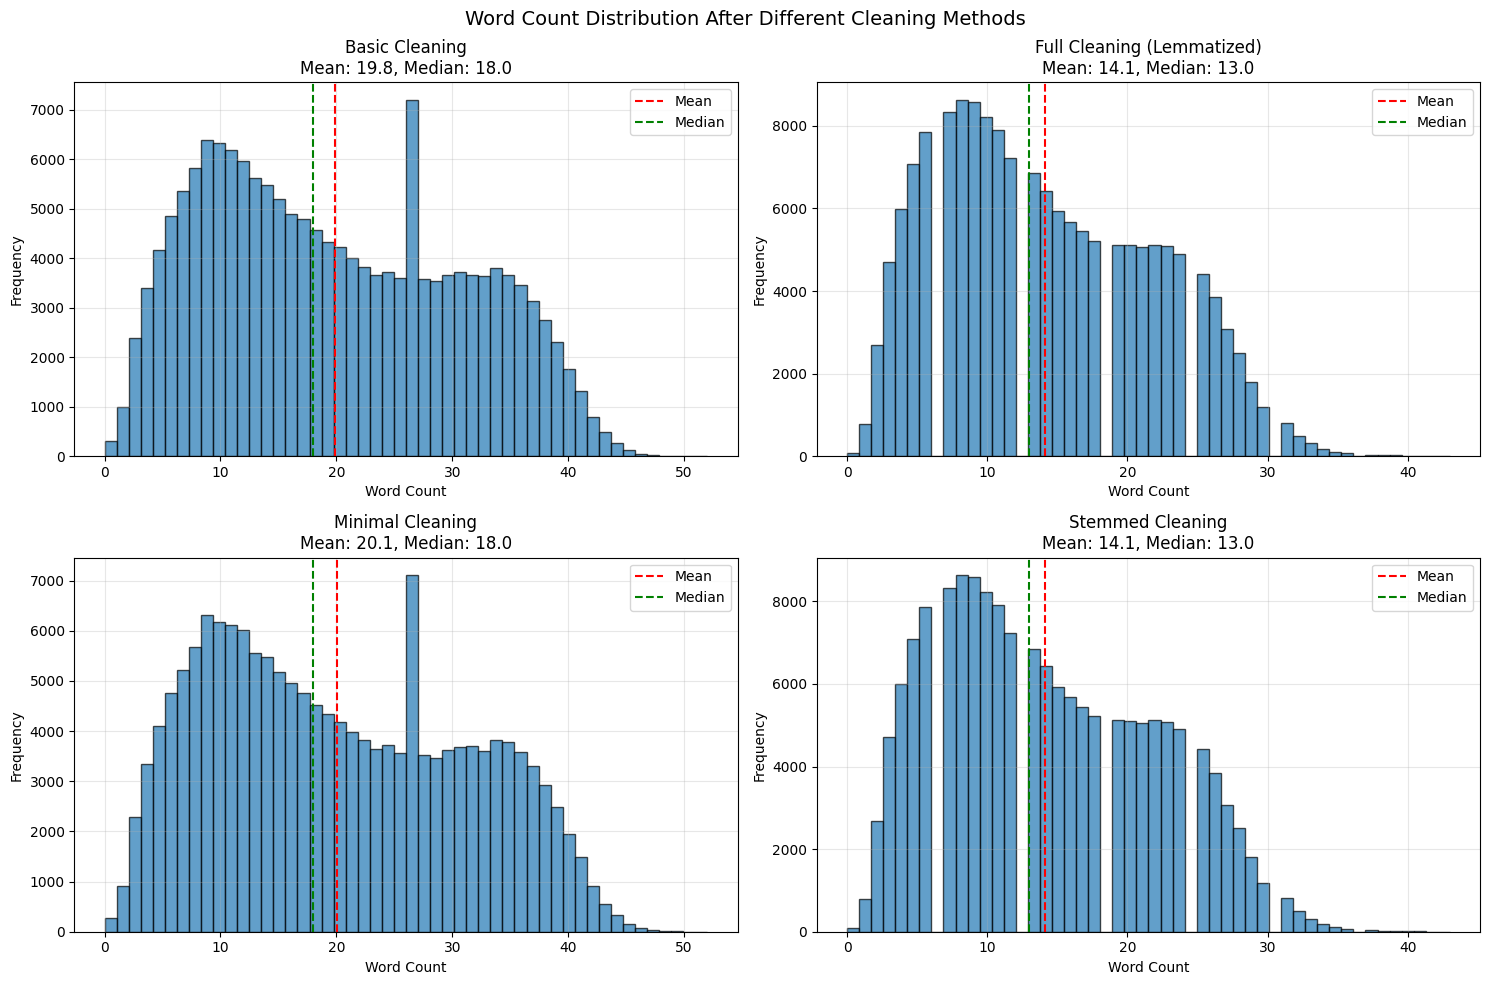

In [16]:
# Visualize word count distribution after cleaning
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

cleaning_methods = [
    ('text_basic', 'Basic Cleaning'),
    ('text_full', 'Full Cleaning (Lemmatized)'),
    ('text_minimal', 'Minimal Cleaning'),
    ('text_stemmed', 'Stemmed Cleaning'),
]

for ax, (col, title) in zip(axes.flatten(), cleaning_methods):
    word_counts = df[col].astype(str).apply(lambda x: len(x.split()) if x else 0)
    ax.hist(word_counts, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Word Count')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{title}\nMean: {word_counts.mean():.1f}, Median: {word_counts.median():.1f}')
    ax.axvline(word_counts.mean(), color='red', linestyle='--', label='Mean')
    ax.axvline(word_counts.median(), color='green', linestyle='--', label='Median')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Word Count Distribution After Different Cleaning Methods', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Handle Empty Texts

Check for and handle any empty texts that resulted from cleaning.

In [17]:
# Check for empty texts in each cleaned column
print("Empty Text Analysis")
print("="*60)

for col in ['text_basic', 'text_full', 'text_minimal', 'text_stemmed']:
    empty_mask = df[col].astype(str).str.strip() == ''
    empty_count = empty_mask.sum()
    print(f"{col}: {empty_count} empty texts ({empty_count/len(df)*100:.2f}%)")

# Identify rows that are empty in all cleaning methods
all_empty_mask = (
    (df['text_basic'].astype(str).str.strip() == '') &
    (df['text_full'].astype(str).str.strip() == '') &
    (df['text_minimal'].astype(str).str.strip() == '')
)
print(f"\nRows empty in all methods: {all_empty_mask.sum()}")

# Show examples of problematic texts
if all_empty_mask.sum() > 0:
    print("\nExamples of texts that became empty:")
    print(df.loc[all_empty_mask, 'clean_text'].head(5))

Empty Text Analysis
text_basic: 11 empty texts (0.01%)
text_full: 82 empty texts (0.05%)
text_minimal: 5 empty texts (0.00%)
text_stemmed: 82 empty texts (0.05%)

Rows empty in all methods: 5

Examples of texts that became empty:
148       NaN
77224        
158694    NaN
159443    NaN
160560    NaN
Name: clean_text, dtype: object


In [18]:
# Remove rows where minimal cleaning resulted in empty text
# (these are likely invalid/corrupted records)
print(f"Original dataset size: {len(df)}")

# Create mask for non-empty minimal text (most permissive cleaning)
valid_mask = df['text_minimal'].astype(str).str.strip() != ''

# Filter dataset
df_clean = df[valid_mask].copy()
print(f"After removing empty texts: {len(df_clean)}")
print(f"Removed: {len(df) - len(df_clean)} records")

# Reset index
df_clean = df_clean.reset_index(drop=True)

# Verify sentiment distribution is preserved
print("\nSentiment Distribution (After Cleaning):")
print(df_clean['category'].value_counts().sort_index())

Original dataset size: 162980
After removing empty texts: 162975
Removed: 5 records

Sentiment Distribution (After Cleaning):
category
-1.0    35509
 0.0    55210
 1.0    72249
Name: count, dtype: int64


## 10. Vocabulary Analysis

Analyze the vocabulary to understand the most common words and potential issues.

In [19]:
def get_vocabulary_stats(text_series, name, top_n=20):
    """
    Get vocabulary statistics for a text series.
    """
    all_words = ' '.join(text_series.astype(str)).split()
    word_freq = Counter(all_words)

    print(f"\n{'='*60}")
    print(f"Vocabulary Statistics: {name}")
    print(f"{'='*60}")
    print(f"Total words: {len(all_words):,}")
    print(f"Unique words: {len(word_freq):,}")
    print(f"Vocabulary density: {len(word_freq)/len(all_words)*100:.2f}%")
    print(f"\nTop {top_n} most common words:")

    for word, count in word_freq.most_common(top_n):
        print(f"  {word}: {count:,}")

    return word_freq

# Analyze vocabulary for basic and full cleaned text
vocab_basic = get_vocabulary_stats(df_clean['text_basic'], 'Basic Cleaning')
vocab_full = get_vocabulary_stats(df_clean['text_full'], 'Full Cleaning (Lemmatized)')


Vocabulary Statistics: Basic Cleaning
Total words: 3,233,992
Unique words: 100,769
Vocabulary density: 3.12%

Top 20 most common words:
  modi: 155,638
  the: 104,506
  and: 67,358
  for: 52,451
  you: 38,985
  not: 29,348
  india: 29,181
  will: 28,961
  this: 28,617
  that: 28,194
  are: 27,999
  with: 21,021
  has: 20,121
  have: 19,814
  but: 18,574
  all: 17,949
  from: 16,422
  his: 16,325
  was: 16,324
  they: 14,706

Vocabulary Statistics: Full Cleaning (Lemmatized)
Total words: 2,305,176
Unique words: 95,766
Vocabulary density: 4.15%

Top 20 most common words:
  modi: 155,638
  india: 31,020
  bjp: 14,664
  people: 14,419
  like: 12,943
  congress: 12,935
  election: 11,718
  narendra: 11,469
  vote: 10,935
  govt: 10,035
  one: 9,663
  year: 9,501
  indian: 9,384
  say: 9,255
  time: 8,905
  country: 8,699
  dont: 8,406
  modis: 7,794
  nation: 7,400
  know: 7,340


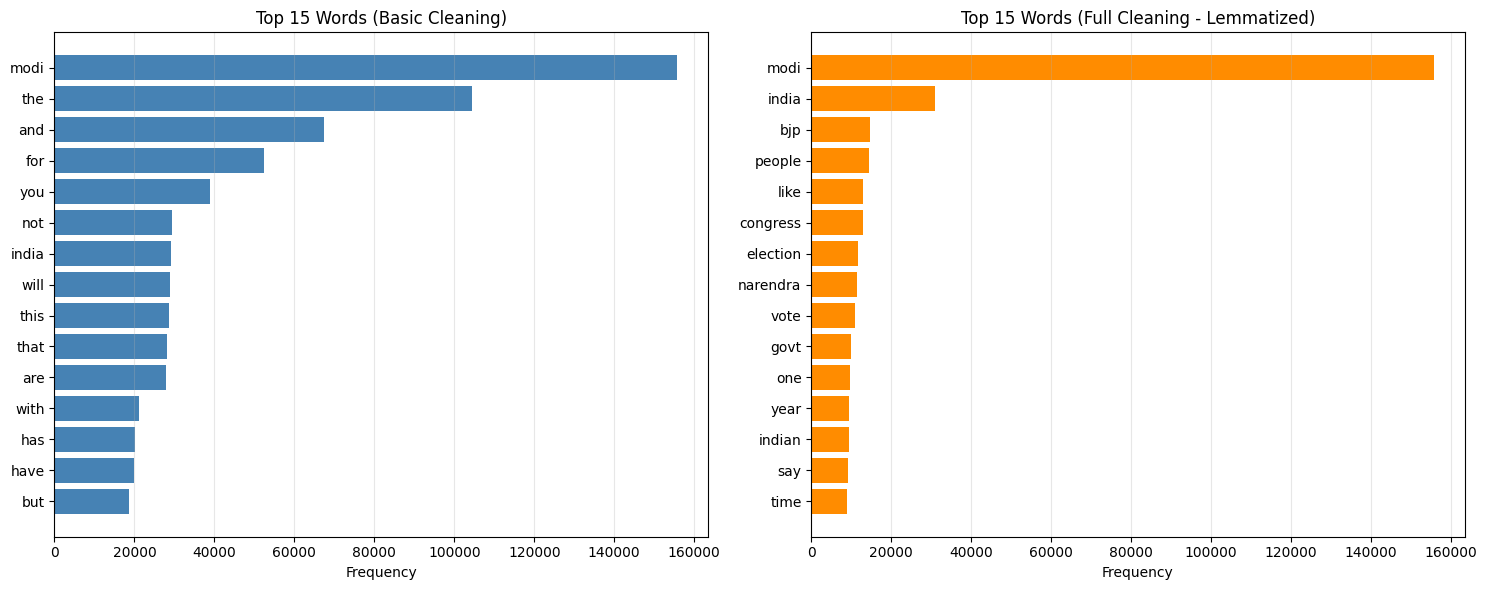

In [20]:
# Visualize top words comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Basic cleaning top words
top_basic = dict(vocab_basic.most_common(15))
axes[0].barh(list(top_basic.keys())[::-1], list(top_basic.values())[::-1], color='steelblue')
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words (Basic Cleaning)')
axes[0].grid(alpha=0.3, axis='x')

# Full cleaning top words
top_full = dict(vocab_full.most_common(15))
axes[1].barh(list(top_full.keys())[::-1], list(top_full.values())[::-1], color='darkorange')
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words (Full Cleaning - Lemmatized)')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 11. Save Cleaned Data

Save the cleaned datasets to the processed data directory for use in subsequent notebooks.

In [21]:
import os

# Create processed directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Prepare final dataframes for different use cases

# 1. Main cleaned dataset with all versions
df_final = df_clean[['clean_text', 'category', 'text_basic', 'text_full', 'text_minimal', 'text_stemmed']].copy()
df_final.columns = ['original_text', 'label', 'text_basic', 'text_lemmatized', 'text_minimal', 'text_stemmed']

# Map labels for clarity
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
df_final['label_name'] = df_final['label'].map(label_map)

# Save main dataset
df_final.to_csv('../data/processed/twitter_cleaned.csv', index=False)
print(f"✓ Saved main cleaned dataset: ../data/processed/twitter_cleaned.csv")
print(f"  Shape: {df_final.shape}")

# 2. Save individual cleaned versions for quick loading
df_basic = df_final[['text_basic', 'label', 'label_name']].copy()
df_basic.to_csv('../data/processed/twitter_basic.csv', index=False)
print(f"✓ Saved basic cleaned: ../data/processed/twitter_basic.csv")

df_lemma = df_final[['text_lemmatized', 'label', 'label_name']].copy()
df_lemma.to_csv('../data/processed/twitter_lemmatized.csv', index=False)
print(f"✓ Saved lemmatized: ../data/processed/twitter_lemmatized.csv")

df_minimal = df_final[['text_minimal', 'label', 'label_name']].copy()
df_minimal.to_csv('../data/processed/twitter_minimal.csv', index=False)
print(f"✓ Saved minimal cleaned: ../data/processed/twitter_minimal.csv")

print(f"\n{'='*60}")
print("All datasets saved successfully!")
print(f"{'='*60}")

✓ Saved main cleaned dataset: ../data/processed/twitter_cleaned.csv
  Shape: (162975, 7)
✓ Saved basic cleaned: ../data/processed/twitter_basic.csv
✓ Saved lemmatized: ../data/processed/twitter_lemmatized.csv
✓ Saved minimal cleaned: ../data/processed/twitter_minimal.csv

All datasets saved successfully!


In [22]:
# Display final dataset summary
print("Final Dataset Summary")
print("="*60)
print(f"\nShape: {df_final.shape}")
print(f"\nColumns: {df_final.columns.tolist()}")
print(f"\nLabel Distribution:")
print(df_final['label_name'].value_counts())
print(f"\nSample Records:")
df_final.head()

Final Dataset Summary

Shape: (162975, 7)

Columns: ['original_text', 'label', 'text_basic', 'text_lemmatized', 'text_minimal', 'text_stemmed', 'label_name']

Label Distribution:
label_name
positive    72249
neutral     55210
negative    35509
Name: count, dtype: int64

Sample Records:


,original_text,label,text_basic,text_lemmatized,text_minimal,text_stemmed,label_name
0,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit ps...,-1.0,when modi promised minimum government maximum governance expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus...,modi promised minimum government maximum governance expected begin difficult job reforming state take year get justice state business exit psus temple,when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit ps...,modi promis minimum govern maximum govern expect begin difficult job reform state take year get justic state busi exit psu templ,negative
1,talk all the nonsense and continue all the drama will vote for modi,0.0,talk all the nonsense and continue all the drama will vote for modi,talk nonsense continue drama vote modi,talk all the nonsense and continue all the drama will vote for modi,talk nonsens continu drama vote modi,neutral
2,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,1.0,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,say vote modi welcome bjp told rahul main campaigner modi think modi relax,what did just say vote for modi welcome bjp told you rahul the main campaigner for modi think modi should just relax,say vote modi welcom bjp told rahul main campaign modi think modi relax,positive
3,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming...,1.0,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming...,asking supporter prefix chowkidar name modi great service confusion read crustal clear crass filthy nonsensical see abuse coming chowkidars,asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming...,ask support prefix chowkidar name modi great servic confus read crustal clear crass filthi nonsens see abus come chowkidar,positive
4,answer who among these the most powerful world leader today trump putin modi may,1.0,answer who among these the most powerful world leader today trump putin modi may,answer among powerful world leader today trump putin modi may,answer who among these the most powerful world leader today trump putin modi may,answer among power world leader today trump putin modi may,positive


## 12. Summary & Recommendations

### Cleaning Methods Summary

| Method | Best For | Description |
|--------|----------|-------------|
| **Basic** | Word2Vec, GloVe, FastText | Removes URLs, mentions, special chars; lowercase |
| **Lemmatized** | TF-IDF, Bag of Words, Classical ML | Basic + stopword removal + lemmatization |
| **Minimal** | BERT, RoBERTa, Transformers | Only removes URLs; preserves natural text |
| **Stemmed** | Comparison experiments | Basic + stemming (more aggressive reduction) |

### Recommendations for Model Training

1. **For Word Embeddings (Word2Vec, GloVe, FastText)**:
   - Use `text_basic` - preserves word forms while removing noise
   
2. **For TF-IDF / Classical ML (SVM, Naive Bayes, Random Forest)**:
   - Use `text_lemmatized` - reduces vocabulary size, removes stopwords
   
3. **For Transformer Models (BERT, RoBERTa, DistilBERT)**:
   - Use `text_minimal` - transformers handle raw text better
   
4. **For Comparison Studies**:
   - Use `text_stemmed` to compare with lemmatization